In [101]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint


In [102]:
# Define the file paths
subdirectory = "pickle_data_Saisonbrot"
training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
test_labels_path = f"{subdirectory}/test_labels.pkl"

# Read the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
#test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
#print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(training_labels.head())


Loaded Training features dimensions: (236, 24)
Loaded Validation features dimensions: (56, 24)
Loaded Test features dimensions: (56, 24)

Loaded Training labels dimensions: (236, 1)
Loaded Validation labels dimensions: (56, 1)

First few rows of loaded training features:
      Temp_Cold_current  Temp_Mild_current  Cloud_Clear_current  \
9042                  0                  1                    0   
9043                  0                  1                    0   
9044                  0                  1                    0   
9045                  0                  1                    0   
9046                  0                  1                    0   

      Cloud_Cloudy_current  Weather_Moderate_current  Samstag_current  \
9042                     0                         0                0   
9043                     1                         0                0   
9044                     0                         0                1   
9045                     1       

In [103]:
#Defining the Neural Network
#Now, let's define our neural network. We are using a Sequential model definition from Keras with batch normalization and dense layers.

model = Sequential([
    InputLayer(shape=(training_features.shape[1], )),
    Dropout(0.15),
    Dense(30, activation='relu', kernel_initializer="he_normal", kernel_regularizer=l2(0.1)),
    Dropout(0.15),
    Dense(20, activation='relu', kernel_initializer="he_normal", kernel_regularizer=l2(0.1)),

    Dense(1)
])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_18 (Dropout)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 30)             │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,391 (5.43 KB)

 Trainable params: 1,391 (5.43 KB)

 Non-trainable params: 0 (0.00 B)

In [104]:
# SGD with optimized parameters
optimizer = SGD(
    #learning_rate=0.003, durch den lr_scheduler geregelt
    momentum=0.9,    # Add momentum to help escape local minima
    nesterov=True,   # Use Nesterov momentum for better convergence
)

model.compile(
    loss="huber",    # More robust to outliers
    optimizer=optimizer,
    metrics=['mape']
)

# Custom learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 50.0
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return max(lr, 1e-5)  # Don't let LR get too small

history = model.fit(
    training_features, 
    training_labels, 
    epochs=500,
    batch_size=8,   # Smaller batch size works better with SGD
    verbose=1,
    validation_data=(validation_features, validation_labels),
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            mode='min'
        ),
        LearningRateScheduler(lr_schedule),
        ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            mode='min'
        )
    ]
)

Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 78.4282 - mape: 100.7503 - val_loss: 74.2103 - val_mape: 97.9860 - learning_rate: 0.0010
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 71.7230 - mape: 97.1110 - val_loss: 69.0144 - val_mape: 89.4776 - learning_rate: 0.0010
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 65.7035 - mape: 84.1420 - val_loss: 35.2345 - val_mape: 42.8594 - learning_rate: 0.0010
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 34.0294 - mape: 43.6904 - val_loss: 26.3848 - val_mape: 43.0519 - learning_rate: 0.0010
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 32.9819 - mape: 43.0114 - val_loss: 24.7945 - val_mape: 43.7803 - learning_rate: 0.0010
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 29.5451 - mape: 44.0234 - val_loss: 23.3350 - val_mape: 37.8756 - learning_rate: 0.0010
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 28.9463 - mape: 41.4855 - val_loss: 24.3474 - val_map

In [105]:
# Saving the trained Model
model.save("python_model_Saisonbrot.h5")

In [106]:
# Making Predictions and Evaluating the Model
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
MAPE on the Training Data: 31.51%
MAPE on the Validation Data: 35.91%


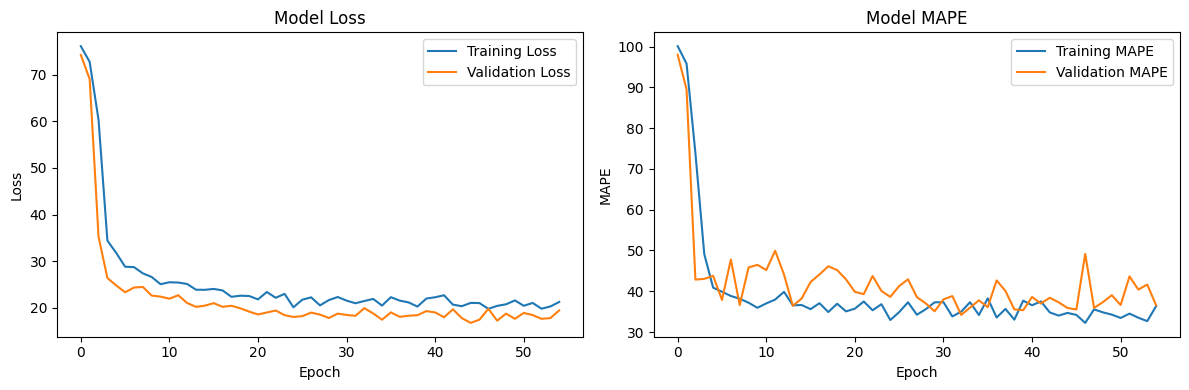

In [112]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mape'], label='Training MAPE')
plt.plot(history.history['val_mape'], label='Validation MAPE')
plt.title('Model MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend()

plt.tight_layout()
plt.show()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


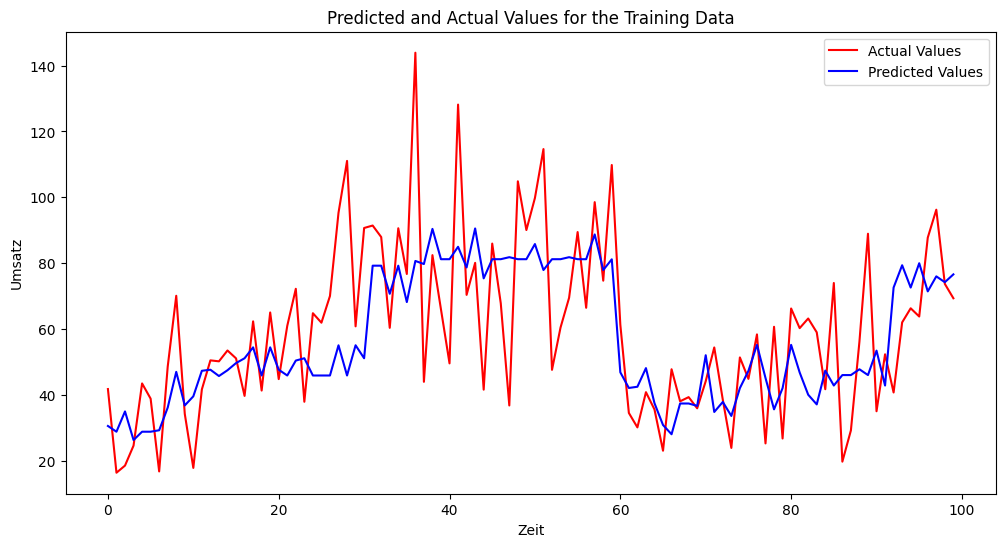

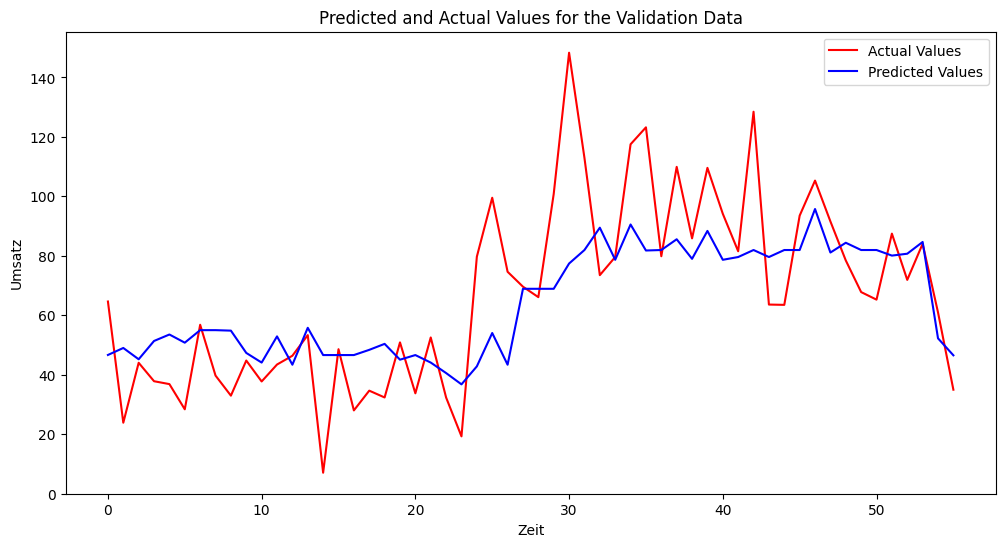

In [113]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Zeit')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

***VORHERSAGE TESTZEITRAUM***

In [114]:
test_predictions = model.predict(test_features)
#print("Predictions for test data:", test_predictions[:5])  # Display first 5 predictions
# Größe des Arrays anzeigen
print("Größe des Arrays (shape):", test_predictions.shape)
test_predictions = pd.DataFrame(test_predictions)
test_predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Größe des Arrays (shape): (56, 1)


,0
0,38.907681
1,37.167587
2,59.877872
3,44.608414
4,41.665302
5,43.120010
6,49.139664
7,36.367081
8,43.120010
9,45.444569


In [115]:
data_test = pd.read_csv("../../../0_DataPreparation/00_data/data_with_lag/Testdaten_with_lag.csv")
data_test = data_test[data_test["Warengruppe_6"] == 1]
data_test

,id,Datum,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,Temp_Very_Cold_current,Temp_Very_Cold_prev,...,zwischen_den_jahren_next,Number_of_ships_scaled_current,Number_of_ships_scaled_prev,Number_of_ships_scaled_next,Cloud_ok_current,Cloud_ok_prev,Cloud_ok_next,Wind_ok_current,Wind_ok_prev,Wind_ok_next
1774,1811016,2018-11-01,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.2,0.0,1,0.0,0.0,1,1.0,1.0
1775,1811026,2018-11-02,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.0,0.0,0,1.0,1.0,1,1.0,1.0
1776,1811036,2018-11-03,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.0,0.0,1,0.0,0.0,1,1.0,1.0
1777,1811046,2018-11-04,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.0,0.2,0,1.0,0.0,1,1.0,1.0
1778,1811056,2018-11-05,0,0,0,0,0,1,0,0.0,...,0.0,0.2,0.0,0.2,0,0.0,0.0,1,1.0,1.0
1779,1811066,2018-11-06,0,0,0,0,0,1,0,0.0,...,0.0,0.2,0.2,0.4,0,0.0,1.0,1,1.0,1.0
1780,1811076,2018-11-07,0,0,0,0,0,1,0,0.0,...,0.0,0.4,0.2,1.0,1,0.0,0.0,1,1.0,1.0
1781,1811086,2018-11-08,0,0,0,0,0,1,0,0.0,...,0.0,1.0,0.4,0.2,0,1.0,0.0,1,1.0,1.0
1782,1811096,2018-11-09,0,0,0,0,0,1,0,0.0,...,0.0,0.2,1.0,0.0,0,0.0,0.0,1,1.0,1.0
1783,1811106,2018-11-10,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.2,0.0,0,0.0,0.0,1,1.0,1.0


In [116]:
# Erstelle Ziel csv Datei

predictions_df = pd.DataFrame({
    'id': data_test['id'].values,
    'Umsatz': test_predictions[0].values
}).reset_index(drop=True)

# Save to a CSV file
#output_csv_path = "/workspaces/bakery_sales_prediction/3_Model/02_Franz/V3_lag/Umsatzvorhersage_Saisonbrot_Hochladeformat.csv"

predictions_df.to_csv('Saisonbrot_Umsatzvorhersage.csv', index=False)
print(f"CSV Datei erstellt")

CSV Datei erstellt
